In [7]:
import os
import pandas as pd
os.chdir('..')
from db_connection.connection import PostgresConnection

from src.utils import missing_values_table, convert_bytes_to_megabytes

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

In [3]:
db = PostgresConnection(dbname='postgres', user='postgres', password='ocho')
db.connect()

# Example query
query = "SELECT * FROM xdr_data"
result = db.execute_query(query)

# Convert the result to a Pandas DataFrame
df = pd.DataFrame(result, columns=[desc[0] for desc in db.cursor.description])
print(df.head())  # Display the first few rows of the DataFrame

# Close the connection when done
db.close_connection()


Connected to PostgreSQL database!
      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...         

In [4]:
missing_values_df = missing_values_table(df)
print("Missing Values in df:")
print(missing_values_df)

Your selected dataframe has 55 columns.
There are 41 columns that have missing values.
Missing Values in df:
                                          Missing Values  % of Total Values  \
Nb of sec with 37500B < Vol UL                    130254               86.8   
Nb of sec with 6250B < Vol UL < 37500B            111843               74.6   
Nb of sec with 125000B < Vol DL                    97538               65.0   
TCP UL Retrans. Vol (Bytes)                        96649               64.4   
Nb of sec with 31250B < Vol DL < 125000B           93586               62.4   
Nb of sec with 1250B < Vol UL < 6250B              92894               61.9   
Nb of sec with 6250B < Vol DL < 31250B             88317               58.9   
TCP DL Retrans. Vol (Bytes)                        88146               58.8   
HTTP UL (Bytes)                                    81810               54.5   
HTTP DL (Bytes)                                    81474               54.3   
Avg RTT DL (ms)       

In [5]:
df['x'] = convert_bytes_to_megabytes(df, 'HTTP DL (Bytes)')

print(df)

           Bearer Id            Start  Start ms              End  End ms  \
0       1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1       1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2       1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3       1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4       1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   
...              ...              ...       ...              ...     ...   
149996  7.277826e+18   4/29/2019 7:28     451.0   4/30/2019 6:02   214.0   
149997  7.349883e+18   4/29/2019 7:28     483.0  4/30/2019 10:41   187.0   
149998  1.311448e+19   4/29/2019 7:28     283.0  4/30/2019 10:46   810.0   
149999  1.311448e+19   4/29/2019 7:28     696.0  4/30/2019 10:40   327.0   
150000           NaN             None       NaN             None     NaN   

        Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0       1823652.0  2.08

In [10]:
# Task 1.1: Aggregating information per user based on specified applications
agg_df = df.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum',
    'Social Media UL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Google UL (Bytes)': 'sum'
})
# Task 1.2: Exploratory Data Analysis
# Describing relevant variables and data types
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 56 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [11]:


# Analyzing basic metrics
print(df.describe())


          Bearer Id       Start ms         End ms     Dur. (ms)          IMSI  \
count  1.490100e+05  150000.000000  150000.000000  1.500000e+05  1.494310e+05   
mean   1.013887e+19     499.188200     498.800880  1.046086e+05  2.082016e+14   
std    2.893173e+18     288.611834     288.097653  8.103762e+04  2.148809e+10   
min    6.917538e+18       0.000000       0.000000  7.142000e+03  2.040471e+14   
25%    7.349883e+18     250.000000     251.000000  5.744050e+04  2.082014e+14   
50%    7.349883e+18     499.000000     500.000000  8.639900e+04  2.082015e+14   
75%    1.304243e+19     749.000000     750.000000  1.324302e+05  2.082018e+14   
max    1.318654e+19     999.000000     999.000000  1.859336e+06  2.140743e+14   

       MSISDN/Number          IMEI  Avg RTT DL (ms)  Avg RTT UL (ms)  \
count   1.489350e+05  1.494290e+05    122172.000000    122189.000000   
mean    4.188282e+10  4.847455e+13       109.795706        17.662883   
std     2.447443e+12  2.241637e+13       619.782739   

In [12]:
# Non-Graphical Univariate Analysis
dispersion_params = df[['Dur. (ms)', 'Total UL (Bytes)', 'Total DL (Bytes)']].std()
print("Dispersion Parameters:\n", dispersion_params)

Dispersion Parameters:
 Dur. (ms)           8.103762e+04
Total UL (Bytes)    1.127639e+07
Total DL (Bytes)    2.441429e+08
dtype: float64


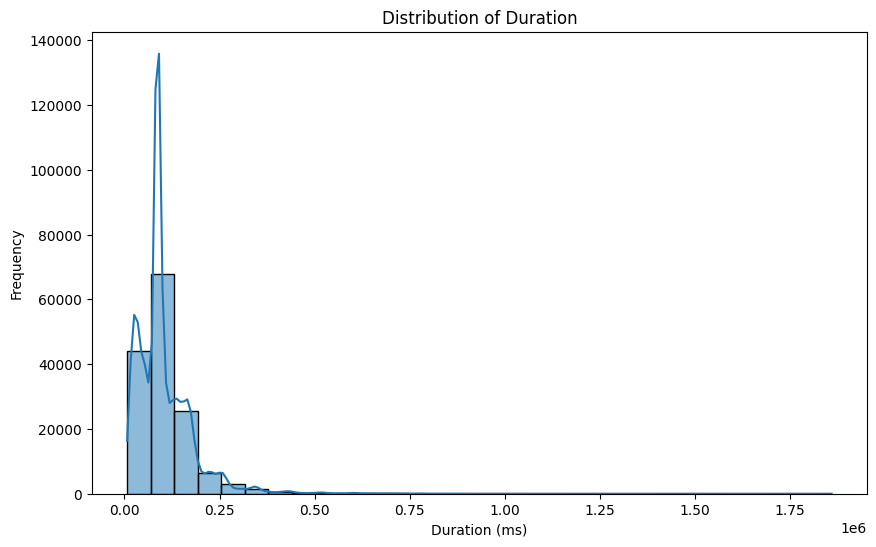

In [13]:
# Graphical Univariate Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['Dur. (ms)'], bins=30, kde=True)
plt.title('Distribution of Duration')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')
plt.show()

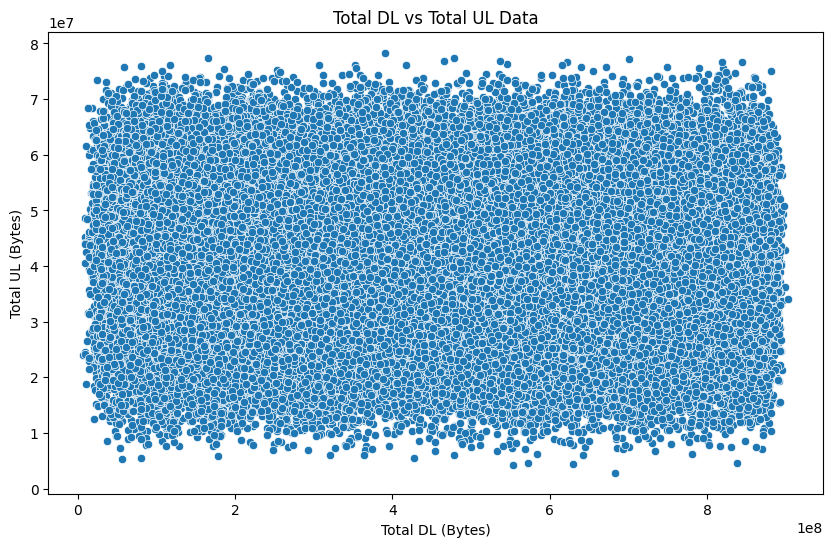

In [14]:
# Bivariate Analysis
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total DL (Bytes)', y='Total UL (Bytes)', data=df)
plt.title('Total DL vs Total UL Data')
plt.xlabel('Total DL (Bytes)')
plt.ylabel('Total UL (Bytes)')
plt.show()

In [18]:


# Segmenting users into decile classes based on total duration and calculating total data per decile class
df['Duration_decile'] = pd.qcut(df['Dur. (ms)'], q=10, labels=False, duplicates='drop')
total_data_per_class = df.groupby('Duration_decile').agg({'Total UL (Bytes)': 'sum', 'Total DL (Bytes)': 'sum'})
total_data_per_class.columns = ['Total UL (Bytes) per Decile', 'Total DL (Bytes) per Decile']
print("Total Data per Decile Class:\n", total_data_per_class)

Total Data per Decile Class:
                  Total UL (Bytes) per Decile  Total DL (Bytes) per Decile
Duration_decile                                                          
0.0                             6.155008e+11                 6.822873e+12
1.0                             6.187469e+11                 6.826451e+12
2.0                             6.170901e+11                 6.861533e+12
3.0                             1.345381e+12                 1.479644e+13
4.0                             5.066822e+11                 5.580722e+12
5.0                             6.167890e+11                 6.821215e+12
6.0                             6.157970e+11                 6.801132e+12
7.0                             6.159194e+11                 6.842822e+12
8.0                             6.162751e+11                 6.843325e+12


In [21]:
# Computing correlation matrix for selected columns
selected_columns = ['Dur. (ms)', 'Total UL (Bytes)', 'Total DL (Bytes)']
correlation_matrix = df[selected_columns].corr()
print("Correlation Matrix:\n", correlation_matrix)


Correlation Matrix:
                   Dur. (ms)  Total UL (Bytes)  Total DL (Bytes)
Dur. (ms)          1.000000         -0.001019          0.000768
Total UL (Bytes)  -0.001019          1.000000         -0.001895
Total DL (Bytes)   0.000768         -0.001895          1.000000


In [27]:

# Principal Component Analysis for dimensionality reduction
features = ['Dur. (ms)', 'Total UL (Bytes)', 'Total DL (Bytes)']
x = df[features].values

# Impute missing values in the input data
imputer = SimpleImputer(strategy='mean')
x_imputed = imputer.fit_transform(x)

# Standardize the imputed data
x_standardized = StandardScaler().fit_transform(x_imputed)

# Perform PCA on the imputed and standardized data
pca = PCA(n_components=2)
principal_components = pca.fit_transform(x_standardized)

principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)


Explained Variance Ratio: [0.33417613 0.33312929]
